In [1]:
import os
os.chdir('../src/')
from twitter_scraper import settings

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

nodes_df = pd.read_csv(settings.NODES_CSV)
# nodes_idx = {user_id: node_id for node_id, user_id in enumerate(nodes_df.user_id.values)}

edges_df = pd.read_csv(settings.EDGES_FOLLOWERS_CSV)

# nodes_df['node_id'] = nodes_df['user_id'].replace(nodes_idx)
# nodes_df = nodes_df.set_index('node_id')
# edges_df['source'] = edges_df['source'].replace(nodes_idx)
# edges_df['target'] = edges_df['target'].replace(nodes_idx)
nodes_df.set_index('user_id', inplace=True)

user_id_str         15178332
followers_count           77
friends_count            336
listed_count               4
favourites_count         364
statuses_count          1475
total_tweets               3
covid_tweets               0
covid_pct                0.0
is_covid               False
Name: 15178332, dtype: object

In [3]:
_nodes = nodes_df
graph = nx.from_pandas_edgelist(edges_df, source='source', target='target', create_using=None)
_nodes = nodes_df[nodes_df.index.isin(graph.nodes)]
# _nodes[['is_covid']].to_dict('index')
nodes_df[nodes_df.index.isin(graph.nodes)]

,user_id_str,followers_count,friends_count,listed_count,favourites_count,statuses_count,total_tweets,covid_tweets,covid_pct,is_covid
user_id,,,,,,,,,,
1000126763379326976,1000126763379326976,223,109,3,97713,2879,154,0,0.000000,False
1000464973955559425,1000464973955559425,10,85,0,2225,526,12,0,0.000000,False
1000540062,1000540062,1058,1779,62,1419,3444,15,0,0.000000,False
1001010281609355264,1001010281609355264,95,843,2,3727,1692,495,2,0.004040,True
1001091505455550464,1001091505455550464,227,488,2,36453,442,2,0,0.000000,False
...,...,...,...,...,...,...,...,...,...,...
998199966274392064,998199966274392064,24,56,0,41064,627,249,0,0.000000,False
998480100453732352,998480100453732352,392,406,0,17312,3766,42,3,0.071429,True
999423708019163136,999423708019163136,97,132,0,3759,841,6,0,0.000000,False


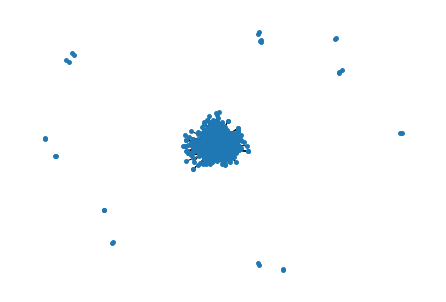

In [7]:
def get_sample_nx_graph(sample_size=None, create_using=None):
    if sample_size:
        _edges = edges_df.sample(sample_size)
    else:
        _edges = edges_df
    
    graph = nx.from_pandas_edgelist(_edges, source='source', target='target', create_using=create_using)
    _nodes = nodes_df[nodes_df.index.isin(graph.nodes)]
    
    if nx.is_directed(graph):
        in_dc = nx.in_degree_centrality(graph)
        out_dc = nx.out_degree_centrality(graph)
        in_d = dict(graph.in_degree)
        out_d = dict(graph.out_degree)
        
        _nodes['in_dc'] = _nodes['user_id'].transform(lambda x: in_dc.get(x, 0))
        _nodes['out_dc'] = _nodes['user_id'].transform(lambda x: out_dc.get(x, 0))
        _nodes['in_d'] = _nodes['user_id'].transform(lambda x: in_d.get(x, 0))
        _nodes['out_d'] = _nodes['user_id'].transform(lambda x: out_d.get(x, 0))

        nx.set_node_attributes(graph, _nodes[['is_covid', 'in_dc', 'out_dc', 'in_d', 'out_d']].to_dict('index'))
    else:
        nx.set_node_attributes(graph, _nodes[['is_covid']].to_dict('index'))
    return graph

G = get_sample_nx_graph(sample_size=None, create_using=None)
nx.draw_spring(G, node_size=15)

In [9]:
def plot_nx_graph(graph, **kwargs):
    plt.figure(figsize=(15, 15))
    nx.draw_spring(graph, **kwargs)
    plt.show()

G = get_sample_nx_graph(sample_size=None, create_using=nx.DiGraph)
plot_nx_graph(G, node_size=15)

KeyError: 'user_id'

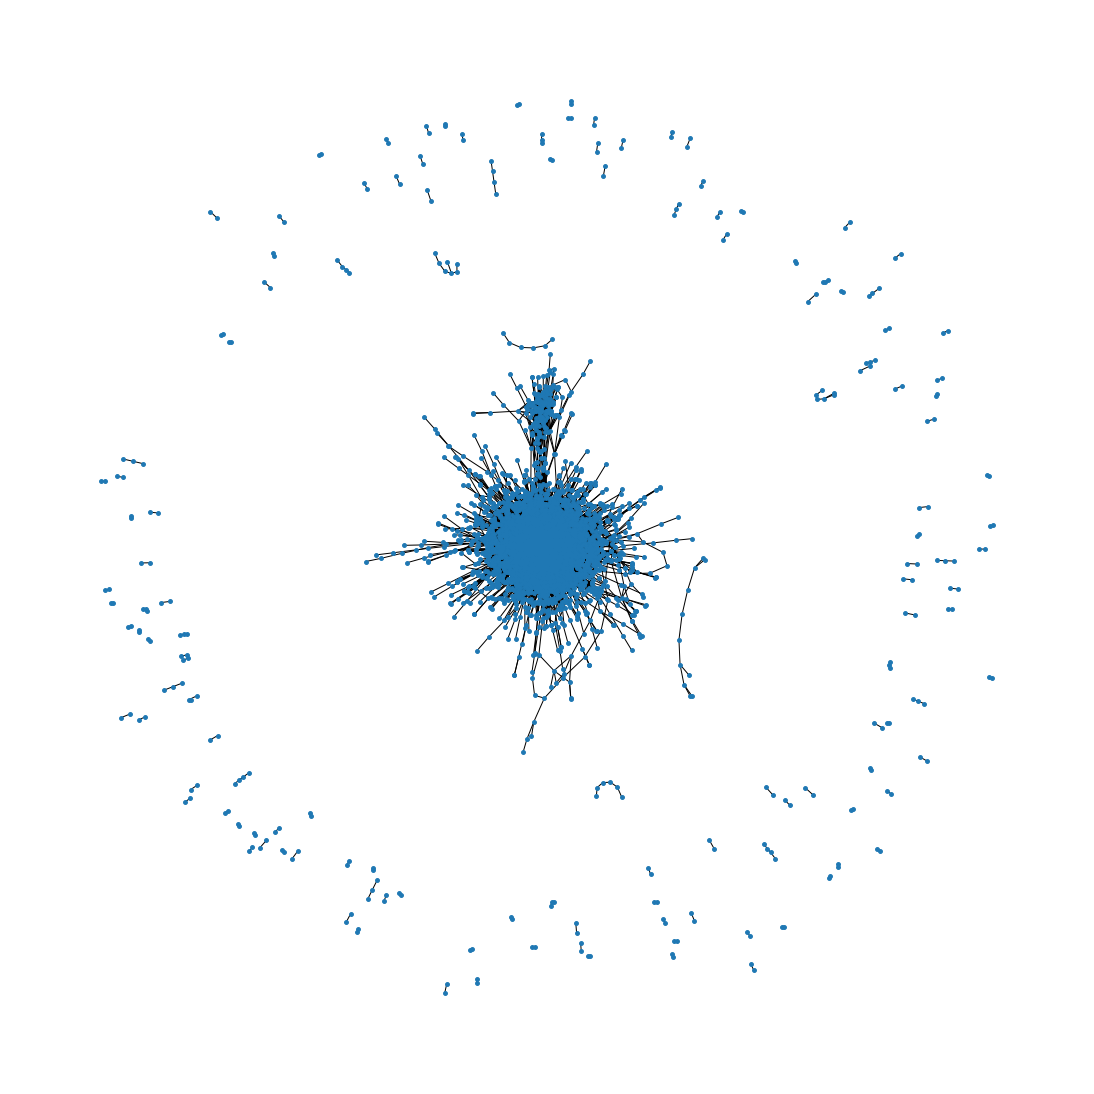

In [10]:
G = get_sample_nx_graph(sample_size=10000, create_using=None)
plot_nx_graph(G, node_size=15)

In [11]:
import random

def get_color_by_attr(graph, nodes_df, attr_name):
    attr_color_map = {
        str(attr): '#' + ''.join([random.choice('0123456789ABCDEF') for i in range(6)])
        for attr in nodes_df[nodes_df.index.isin(graph.nodes)][attr_name].values
    }
    attr_color_map.update({-1: '#000000'})
    node_color = []
    attr_value_map = nodes_df[attr_name].to_dict()
    
    for node in graph.nodes:
        value = str(attr_value_map[node])
        node_color.append(attr_color_map[value])
    return node_color

def plot_nx_graph(graph, nodes_df, color_attr=None, **kwargs):
    plt.figure(figsize=(15, 15))
    if color_attr:
        node_color = get_color_by_attr(graph, nodes_df, color_attr)
        kwargs.update({'node_color': node_color})
    nx.draw_spring(graph, **kwargs)
    plt.show()

G = get_sample_nx_graph(sample_size=5000)
plot_nx_graph(G, nodes_df, color_attr='is_covid', node_size=15)

KeyError: 206646197

<Figure size 1080x1080 with 0 Axes>

In [12]:
from networkx.algorithms import community

def add_communities(graph, nodes_df):
    gn_communities_generator = community.girvan_newman(graph)
    top_level_communities = next(gn_communities_generator)
    next_level_communities = next(gn_communities_generator)
    gn_partitions = sorted(map(sorted, next_level_communities))

    gn_communities = {
        node: i for i, node in enumerate(gn_partitions) for node in nodes_df.index
    }
    nodes_df['gn_community'] = nodes_df.reset_index().node_id.transform(lambda x: gn_communities.get(x, -1))
    return nodes_df

_nodes_df = add_communities(G, nodes_df)
_nodes_df

KeyboardInterrupt: 

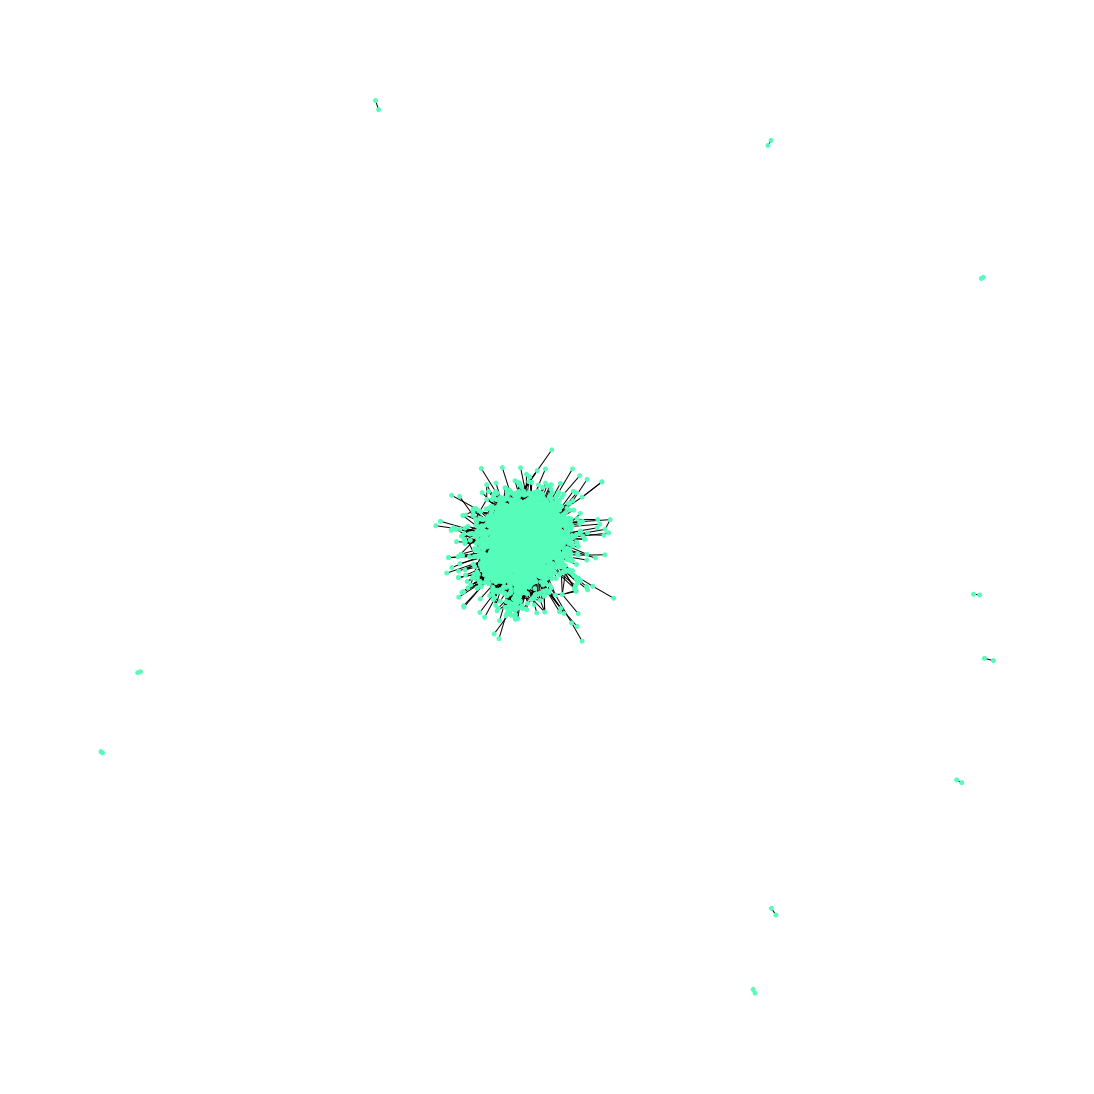

In [60]:
G = get_sample_nx_graph()
plot_nx_graph(G, _nodes_df, color_attr='gn_community', node_size=15)

In [51]:
gn_communities_generator = community.girvan_newman(G)
top_level_communities = next(gn_communities_generator)

In [52]:
top_level_communities

({0,
  2,
  3,
  5,
  8198,
  8199,
  7,
  8201,
  8202,
  11,
  8206,
  15,
  8209,
  8210,
  18,
  20,
  21,
  19,
  23,
  8213,
  25,
  27,
  28,
  29,
  8221,
  8223,
  8224,
  8225,
  37,
  38,
  8232,
  41,
  8234,
  43,
  42,
  8235,
  8238,
  8239,
  47,
  49,
  8242,
  50,
  8244,
  8245,
  52,
  8247,
  8248,
  57,
  58,
  59,
  60,
  8252,
  62,
  56,
  8256,
  65,
  8258,
  67,
  68,
  69,
  8262,
  71,
  72,
  73,
  8264,
  76,
  8269,
  78,
  77,
  79,
  81,
  82,
  83,
  8274,
  86,
  88,
  89,
  90,
  93,
  94,
  96,
  97,
  99,
  103,
  109,
  111,
  112,
  113,
  8306,
  114,
  118,
  8314,
  125,
  128,
  134,
  8329,
  139,
  8331,
  140,
  141,
  144,
  145,
  8337,
  147,
  148,
  8338,
  8340,
  151,
  152,
  153,
  154,
  8341,
  157,
  158,
  160,
  162,
  163,
  165,
  166,
  167,
  8360,
  8361,
  170,
  8359,
  8362,
  169,
  8357,
  175,
  171,
  178,
  8370,
  181,
  182,
  183,
  8375,
  185,
  186,
  8377,
  188,
  8373,
  191,
  192,
  193,
  8388,
  19

In [53]:
next_level_communities = next(gn_communities_generator)

In [54]:
next_level_communities

({0,
  2,
  3,
  5,
  8198,
  8199,
  7,
  8201,
  8202,
  11,
  8206,
  15,
  8209,
  8210,
  18,
  20,
  21,
  19,
  23,
  8213,
  25,
  27,
  28,
  29,
  8221,
  8223,
  8224,
  8225,
  37,
  38,
  8232,
  41,
  42,
  43,
  8235,
  8234,
  40,
  8239,
  47,
  49,
  50,
  8242,
  8244,
  8245,
  52,
  8247,
  8248,
  57,
  58,
  59,
  60,
  8252,
  62,
  56,
  8256,
  65,
  8258,
  67,
  68,
  69,
  8262,
  71,
  72,
  73,
  8264,
  76,
  8269,
  78,
  77,
  79,
  81,
  8274,
  83,
  82,
  86,
  88,
  89,
  90,
  93,
  94,
  96,
  97,
  99,
  103,
  109,
  111,
  112,
  113,
  8306,
  114,
  118,
  8314,
  125,
  128,
  134,
  8329,
  8331,
  140,
  141,
  139,
  144,
  145,
  8337,
  8338,
  148,
  147,
  8340,
  151,
  152,
  153,
  154,
  8341,
  157,
  158,
  160,
  162,
  163,
  165,
  166,
  167,
  8360,
  8361,
  170,
  8359,
  8362,
  8357,
  169,
  175,
  171,
  178,
  8370,
  181,
  182,
  183,
  8375,
  185,
  186,
  8377,
  188,
  8373,
  191,
  192,
  193,
  8388,
  196,

In [55]:
gn_partitions = sorted(map(sorted, next_level_communities))
gn_partitions

[[0,
  2,
  3,
  5,
  7,
  11,
  15,
  18,
  19,
  20,
  21,
  23,
  25,
  27,
  28,
  29,
  37,
  38,
  40,
  41,
  42,
  43,
  47,
  48,
  49,
  50,
  52,
  56,
  57,
  58,
  59,
  60,
  62,
  65,
  67,
  68,
  69,
  71,
  72,
  73,
  76,
  77,
  78,
  79,
  81,
  82,
  83,
  86,
  88,
  89,
  90,
  93,
  94,
  96,
  97,
  99,
  103,
  109,
  111,
  112,
  113,
  114,
  118,
  125,
  128,
  134,
  139,
  140,
  141,
  144,
  145,
  147,
  148,
  151,
  152,
  153,
  154,
  157,
  158,
  160,
  162,
  163,
  165,
  166,
  167,
  169,
  170,
  171,
  175,
  178,
  181,
  182,
  183,
  185,
  186,
  188,
  191,
  192,
  193,
  196,
  198,
  199,
  200,
  202,
  203,
  204,
  205,
  207,
  209,
  210,
  215,
  216,
  218,
  219,
  220,
  223,
  226,
  227,
  228,
  229,
  230,
  231,
  234,
  241,
  244,
  245,
  248,
  255,
  256,
  259,
  262,
  264,
  266,
  267,
  268,
  271,
  272,
  273,
  275,
  276,
  278,
  279,
  281,
  287,
  290,
  293,
  295,
  298,
  299,
  300,
  301,
  30

In [59]:
len(list(filter(lambda x: len(x) > 1, gn_partitions)))

199

In [72]:
partitions = {}
for i, partition in enumerate(gn_partitions):
    for node in partition:
        partitions.update({node: i})
nodes_df['gn_community'] = nodes_df.reset_index().node_id.transform(lambda x: partitions.get(x, -1))

In [ ]:
def add_communities(graph, nodes_df):
    gn_communities_generator = community.girvan_newman(graph)
    top_level_communities = next(gn_communities_generator)
    next_level_communities = next(gn_communities_generator)
    gn_partitions = sorted(map(sorted, next_level_communities))

    gn_communities = {
        node: i for i, node in enumerate(gn_partitions) for node in nodes_df.index
    }
    nodes_df['gn_community'] = nodes_df.reset_index().node_id.transform(lambda x: gn_communities.get(x, -1))
    return nodes_df

In [73]:
nodes_df.gn_community.value_counts()

-1      5290
 0      2884
 35      157
 93       11
 43       11
        ... 
 94        2
 95        2
 96        2
 21        2
 198       2
Name: gn_community, Length: 200, dtype: int64

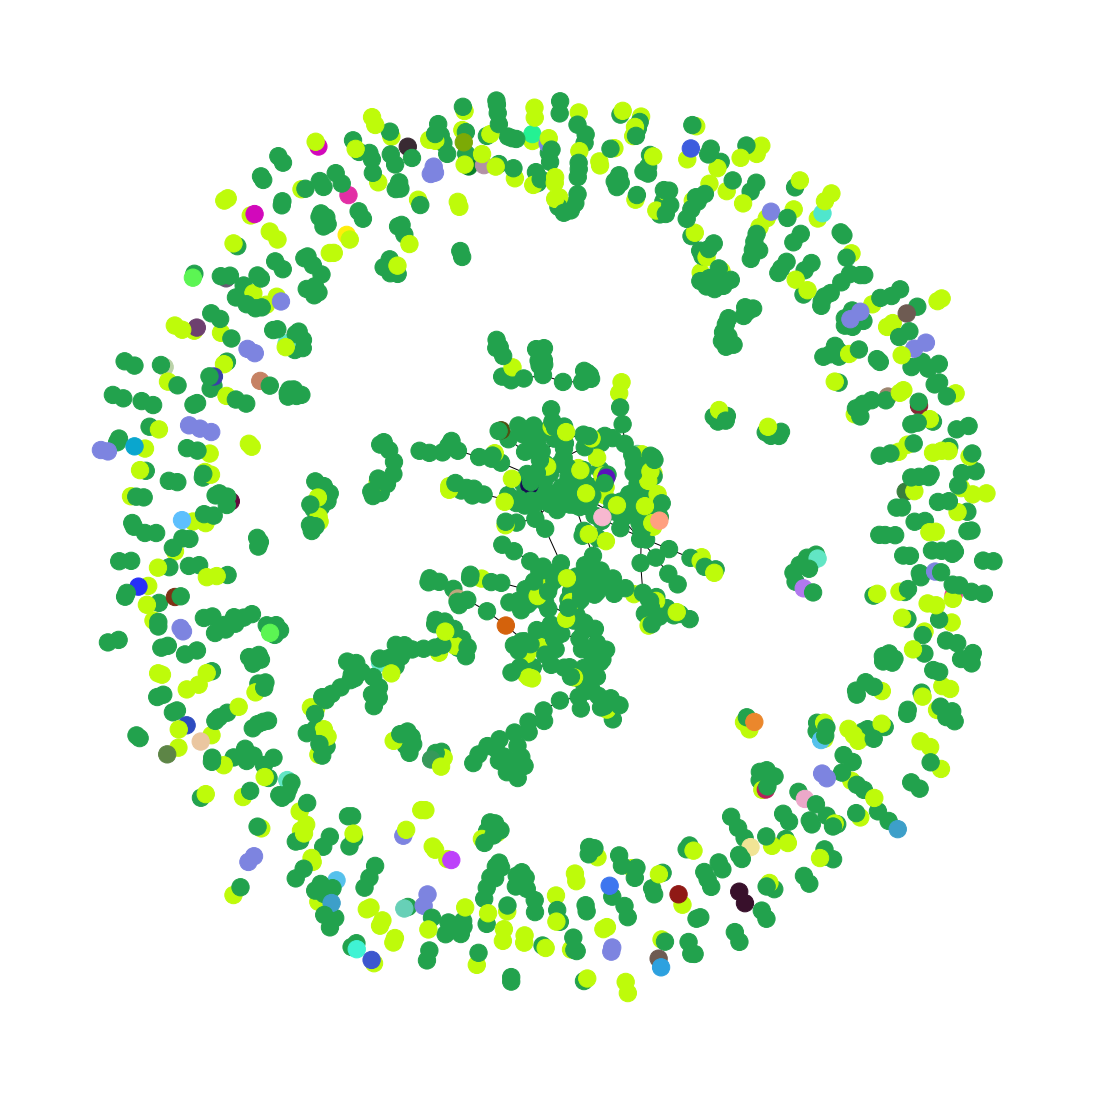

In [74]:
G = get_sample_nx_graph(sample_size=1000)
plot_nx_graph(G, nodes_df, color_attr='gn_community')

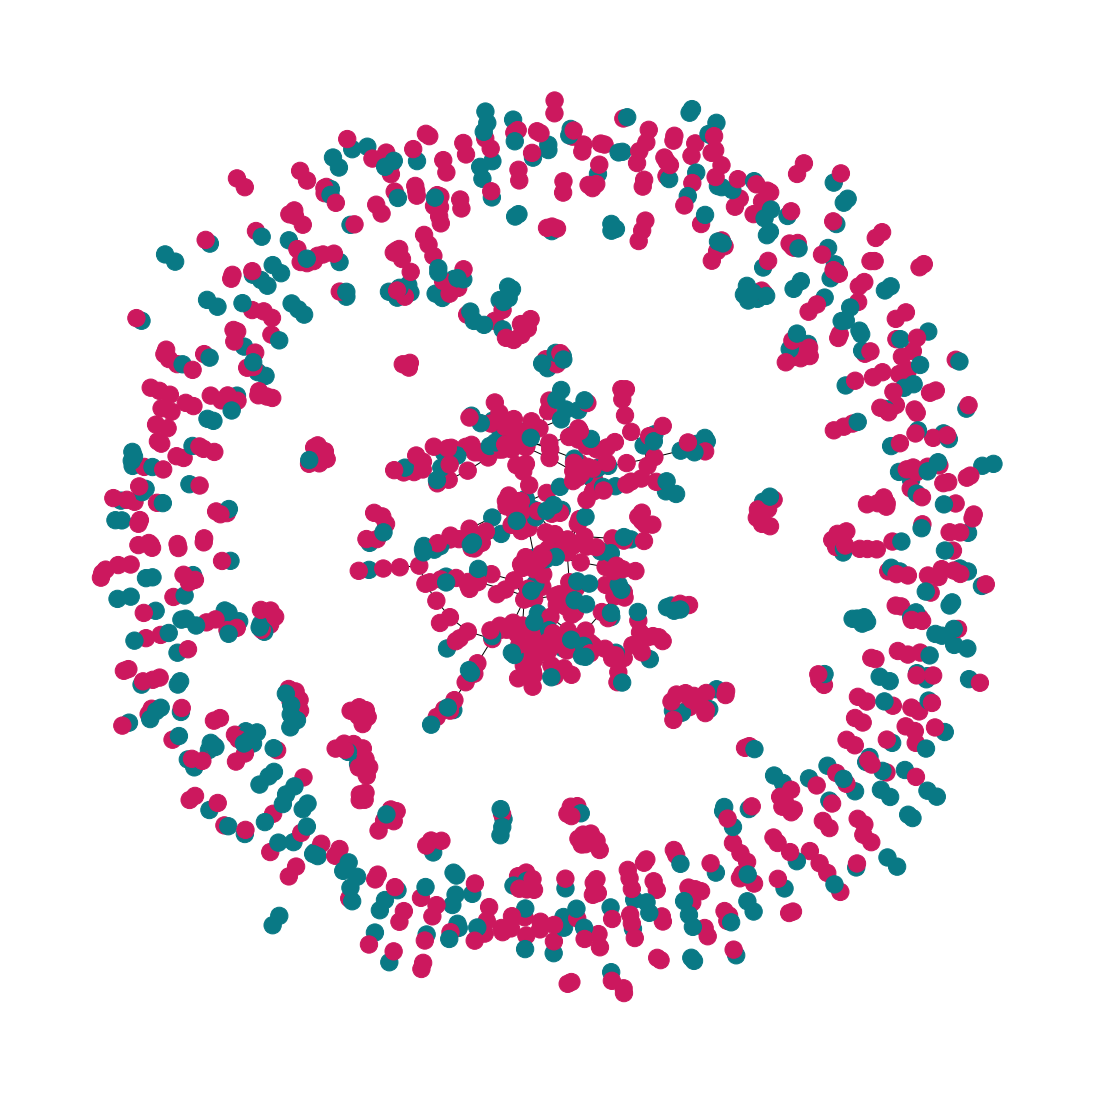

In [76]:
plot_nx_graph(G, nodes_df, color_attr='is_covid')

In [83]:
nodes_df.groupby(['is_covid', 'gn_community']).size().reset_index(name='size').sort_values(by=['gn_community', 'is_covid'])

,is_covid,gn_community,size
0,False,-1,3538
159,True,-1,1752
1,False,0,1212
160,True,0,1672
2,False,1,2
...,...,...,...
283,True,195,2
157,False,196,1
284,True,196,1
158,False,197,2


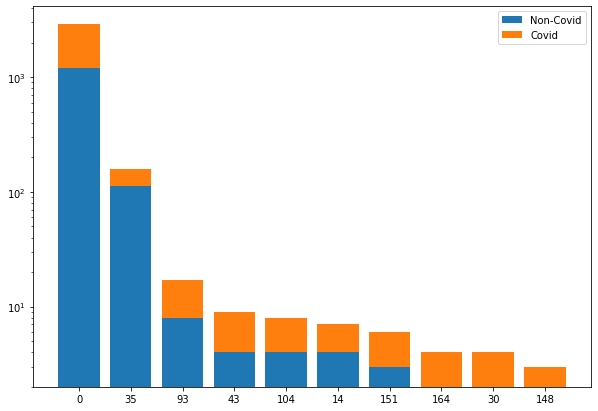

In [125]:
top10_communities = nodes_df[nodes_df.gn_community != -1][['gn_community']].value_counts().head(10).reset_index().gn_community.unique()

fig, ax = plt.subplots(1, figsize=(10, 7))
fig.set_facecolor('white')

non_covid = nodes_df[(nodes_df.gn_community.isin(top10_communities)) & (nodes_df.is_covid == False)].gn_community.value_counts()
covid = nodes_df[(nodes_df.gn_community.isin(top10_communities)) & (nodes_df.is_covid == True)].gn_community.value_counts()

ax.bar(list(map(str, top10_communities)), non_covid, label='Non-Covid', log=True)
ax.bar(list(map(str, top10_communities)), covid, label='Covid', bottom=non_covid, log=True)
ax.legend()

In [104]:
top10_communities

array([  0,  35,  93,  43, 104,  14, 151, 164,  30, 148])